<a href="https://colab.research.google.com/github/keripikkaneboo/Machine-Learning/blob/main/04.%20Week%204/TugasWeek4_compas_scores_two_years.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [33]:
# Set style for visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 8)

# Load the dataset
url = "https://raw.githubusercontent.com/keripikkaneboo/Machine-Learning/refs/heads/main/04.%20Week%204/Datasets/compas-scores-two-years.csv"
data = pd.read_csv(url)
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [34]:
# 1. EXPLORATORY DATA ANALYSIS (EDA)
print("Dataset shape:", data.shape)
print("\nFirst 5 rows:")
print(data.head())

print("\nDataset information:")
print(data.info())

print("\nMissing values in each column:")
print(data.isnull().sum())

print("\nStatistical summary:")
print(data.describe())

# Check target variable distribution
print("\nTarget variable distribution:")
if 'two_year_recid' in data.columns:
    target_col = 'two_year_recid'
    print(data[target_col].value_counts(normalize=True) * 100)
else:
    print("Target column not found. Assuming 'is_recid' as target.")
    target_col = 'is_recid'
    print(data[target_col].value_counts(normalize=True) * 100)

Dataset shape: (7214, 53)

First 5 rows:
   id                name   first         last compas_screening_date   sex  \
0   1    miguel hernandez  miguel    hernandez            2013-08-14  Male   
1   3         kevon dixon   kevon        dixon            2013-01-27  Male   
2   4            ed philo      ed        philo            2013-04-14  Male   
3   5         marcu brown   marcu        brown            2013-01-13  Male   
4   6  bouthy pierrelouis  bouthy  pierrelouis            2013-03-26  Male   

          dob  age          age_cat              race  ...  v_decile_score  \
0  1947-04-18   69  Greater than 45             Other  ...               1   
1  1982-01-22   34          25 - 45  African-American  ...               1   
2  1991-05-14   24     Less than 25  African-American  ...               3   
3  1993-01-21   23     Less than 25  African-American  ...               6   
4  1973-01-22   43          25 - 45             Other  ...               1   

   v_score_text  v_sc

In [35]:
# 2. DATA PREPROCESSING AND FEATURE ENGINEERING
# Let's clean the data and perform feature engineering

# For demonstration, let's define which columns to use
# We'll create a function to handle the preprocessing
def preprocess_compas_data(df, target_col='two_year_recid'):
    # Make a copy to avoid modifying the original
    df_clean = df.copy()

    # Handle missing values - checking for NaN or empty strings
    for col in df_clean.columns:
        if df_clean[col].dtype == 'object':
            df_clean[col] = df_clean[col].replace('', np.nan)

    # Drop rows with missing values in key columns (or impute as needed)
    print(f"Shape before handling missing values: {df_clean.shape}")
    df_clean = df_clean.dropna(subset=[target_col, 'age', 'race', 'sex', 'priors_count'])
    print(f"Shape after handling missing values: {df_clean.shape}")

    # Feature Engineering
    # 1. Age categories
    df_clean['age_cat'] = pd.cut(df_clean['age'],
                               bins=[0, 25, 45, 65, 100],
                               labels=['Less than 25', '25-45', '45-65', 'Greater than 65'])

    # 2. Recidivism risk score (if available)
    if 'decile_score' in df_clean.columns:
        df_clean['risk_category'] = pd.cut(df_clean['decile_score'],
                                        bins=[0, 3, 7, 10],
                                        labels=['Low', 'Medium', 'High'])

    # 3. Prior counts binned
    df_clean['priors_category'] = pd.cut(df_clean['priors_count'],
                                      bins=[-1, 0, 3, 10, 100],
                                      labels=['None', 'Few', 'Several', 'Many'])

    # 4. Length of stay (if available)
    if 'c_jail_in' in df_clean.columns and 'c_jail_out' in df_clean.columns:
        try:
            df_clean['c_jail_in'] = pd.to_datetime(df_clean['c_jail_in'])
            df_clean['c_jail_out'] = pd.to_datetime(df_clean['c_jail_out'])
            df_clean['jail_time_days'] = (df_clean['c_jail_out'] - df_clean['c_jail_in']).dt.days
            # Handle negative values that could arise from data entry errors
            df_clean['jail_time_days'] = df_clean['jail_time_days'].clip(lower=0)
        except:
            print("Could not compute jail time due to date format issues")

    # Select features for modeling
    feature_cols = ['age', 'sex', 'race', 'priors_count', 'age_cat', 'priors_category']

    # Add additional engineered features if they exist
    if 'jail_time_days' in df_clean.columns:
        feature_cols.append('jail_time_days')
    if 'risk_category' in df_clean.columns:
        feature_cols.append('risk_category')

    # Additional potential features based on availability
    additional_features = ['c_charge_degree', 'v_score_text', 'v_decile_score']
    for feat in additional_features:
        if feat in df_clean.columns:
            feature_cols.append(feat)

    # Get final dataset with selected features and target
    X = df_clean[feature_cols]
    y = df_clean[target_col]

    return X, y, df_clean

# Apply preprocessing
X, y, cleaned_data = preprocess_compas_data(data, target_col)

Shape before handling missing values: (7214, 53)
Shape after handling missing values: (7214, 53)


<ipython-input-43-cac6ea9b76b7>:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=target_col, fontsize=7, title_fontsize=8)  # Add legend here, smaller font


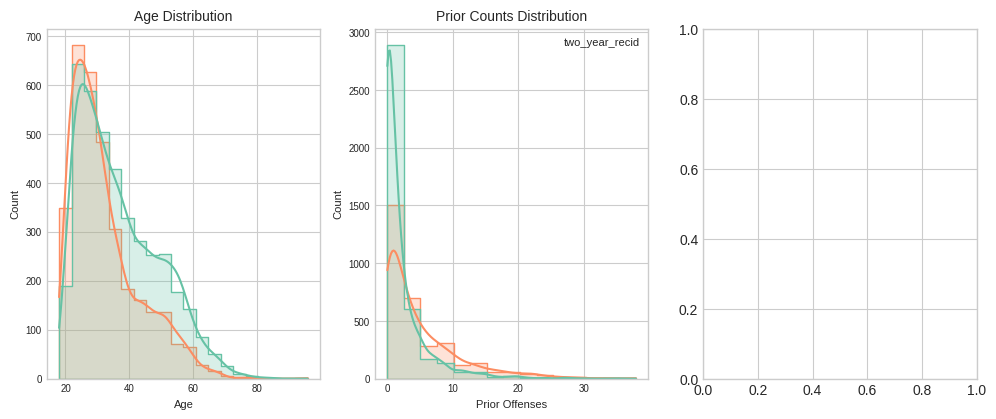

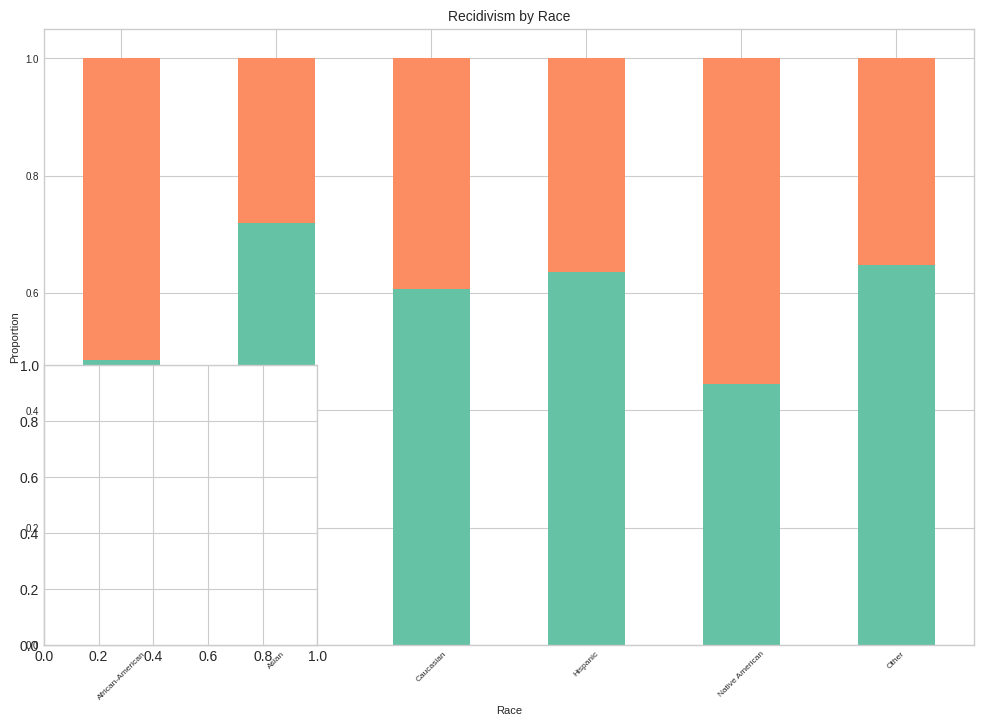

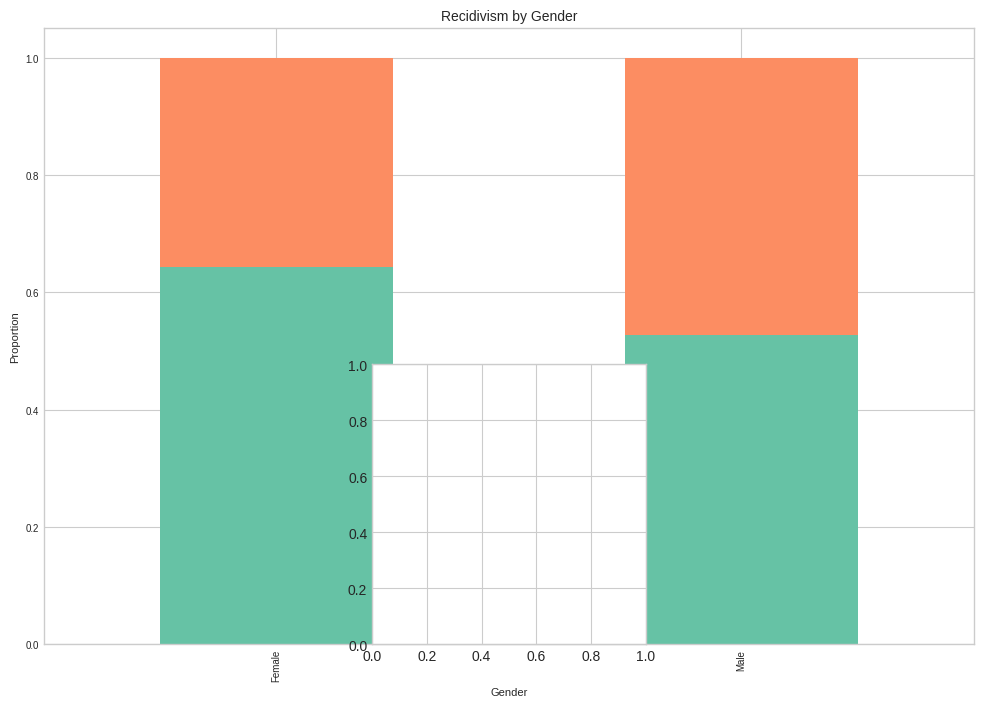

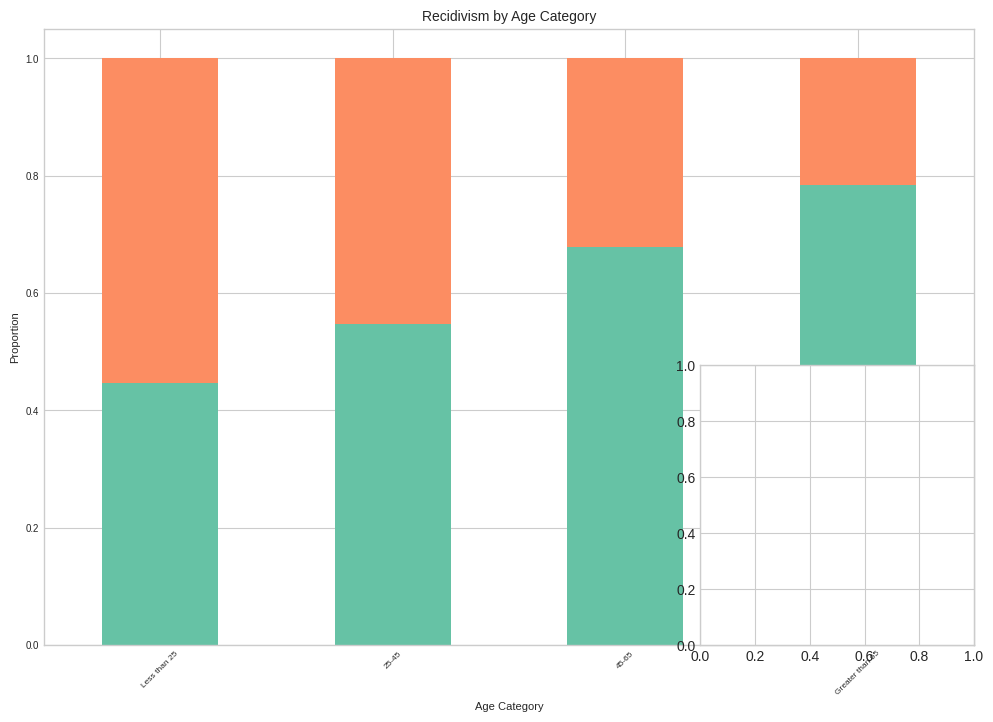

In [43]:
# 3. DATA VISUALIZATION
# Create smaller visualizations for our features

# Set up a smaller figure for multiple plots
plt.figure(figsize=(12, 10))  # Reduced from (20, 15)

# 3.1 Age distribution by recidivism
plt.subplot(2, 3, 1)
sns.histplot(data=cleaned_data, x='age', hue=target_col, bins=20, kde=True,
             element="step", legend=False)  # Use step lines and remove legend to save space
plt.title('Age Distribution', fontsize=10)  # Smaller title
plt.xlabel('Age', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

# 3.2 Prior counts distribution by recidivism
plt.subplot(2, 3, 2)
sns.histplot(data=cleaned_data, x='priors_count', hue=target_col, bins=15, kde=True,
             element="step")  # Use step lines to reduce visual noise
plt.title('Prior Counts Distribution', fontsize=10)
plt.xlabel('Prior Offenses', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.legend(title=target_col, fontsize=7, title_fontsize=8)  # Add legend here, smaller font

# 3.3 Race distribution by recidivism
plt.subplot(2, 3, 3)
race_recid = pd.crosstab(cleaned_data['race'], cleaned_data[target_col], normalize='index')
race_recid.plot(kind='bar', stacked=True, legend=False)  # Remove legend here
plt.title('Recidivism by Race', fontsize=10)
plt.xlabel('Race', fontsize=8)
plt.ylabel('Proportion', fontsize=8)
plt.xticks(rotation=45, fontsize=6)  # Smaller font for tick labels
plt.yticks(fontsize=7)

# 3.4 Gender distribution by recidivism
plt.subplot(2, 3, 4)
gender_recid = pd.crosstab(cleaned_data['sex'], cleaned_data[target_col], normalize='index')
gender_recid.plot(kind='bar', stacked=True, legend=False)  # Remove legend here
plt.title('Recidivism by Gender', fontsize=10)
plt.xlabel('Gender', fontsize=8)
plt.ylabel('Proportion', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

# 3.5 Age Category distribution by recidivism
plt.subplot(2, 3, 5)
age_cat_recid = pd.crosstab(cleaned_data['age_cat'], cleaned_data[target_col], normalize='index')
age_cat_recid.plot(kind='bar', stacked=True, legend=False)  # Remove legend here
plt.title('Recidivism by Age Category', fontsize=10)
plt.xlabel('Age Category', fontsize=8)
plt.ylabel('Proportion', fontsize=8)
plt.xticks(rotation=45, fontsize=6)  # Smaller font for tick labels
plt.yticks(fontsize=7)

# 3.6 Prior Category distribution by recidivism
plt.subplot(2, 3, 6)
prior_cat_recid = pd.crosstab(cleaned_data['priors_category'], cleaned_data[target_col], normalize='index')
prior_cat_recid.plot(kind='bar', stacked=True)
plt.title('Recidivism by Prior Offenses', fontsize=10)
plt.xlabel('Prior Offenses Category', fontsize=8)
plt.ylabel('Proportion', fontsize=8)
plt.xticks(rotation=45, fontsize=6)  # Smaller font
plt.yticks(fontsize=7)
plt.legend(title=target_col, fontsize=7, title_fontsize=8)  # Add legend here, smaller font


plt.tight_layout(pad=1.0)  # Reduced padding
plt.subplots_adjust(bottom=0.15)  # Adjust bottom margin
plt.savefig('compas_eda_visualizations_small.png', dpi=150)  # Higher DPI for better quality at smaller size
plt.close()

# Create smaller correlation plot
plt.figure(figsize=(8, 6))  # Reduced from (10, 8)
numeric_cols = cleaned_data.select_dtypes(include=['number']).columns
correlation = cleaned_data[numeric_cols].corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
sns.heatmap(correlation, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, annot_kws={"size": 7})  # Smaller annotation font
plt.title('Correlation Matrix of Numeric Features', fontsize=11)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig('compas_correlation_matrix_small.png', dpi=150)  # Higher DPI for better quality
plt.close()

In [38]:
# 4. FEATURE ENGINEERING FOR MODELING
# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Define preprocessing for numerical and categorical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# 5. MODEL TRAINING AND EVALUATION
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define models for evaluation
models = {
    'Logistic Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ])
}

# Function to evaluate and visualize model performance
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    # Print metrics
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))

    # Plot confusion matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Plot ROC curve
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.savefig(f'compas_{model_name.replace(" ", "_").lower()}_evaluation.png')
    plt.close()

    return {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    }

In [40]:
# Evaluate each model
results = []
for name, model in models.items():
    result = evaluate_model(model, X_train, X_test, y_train, y_test, name)
    results.append(result)

# Create a comparison DataFrame
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df)

# Feature importance for Random Forest
if 'Random Forest' in models:
    rf_model = models['Random Forest']
    rf_model.fit(X_train, y_train)

    try:
        # Get feature names after one-hot encoding
        preprocessor = rf_model.named_steps['preprocessor']
        feature_names = []

        # Extract feature names from the column transformer
        for name, trans, cols in preprocessor.transformers_:
            if name == 'cat':
                # For categorical features, extract one-hot encoded feature names
                cat_features = trans.named_steps['onehot'].get_feature_names_out(cols)
                feature_names.extend(cat_features)
            else:
                # For numerical features, keep column names
                feature_names.extend(cols)

        # Extract feature importances
        importances = rf_model.named_steps['classifier'].feature_importances_

        # Create a DataFrame for visualization
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        })

        # Sort by importance
        feature_importance = feature_importance.sort_values('importance', ascending=False)

        # Plot feature importance
        plt.figure(figsize=(12, 8))
        sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
        plt.title('Top 15 Feature Importance - Random Forest')
        plt.tight_layout()
        plt.savefig('compas_feature_importance.png')
        plt.close()

        print("\nTop 10 important features:")
        print(feature_importance.head(10))
    except Exception as e:
        print(f"Could not compute feature importance: {str(e)}")

# 6. HYPERPARAMETER TUNING FOR BEST MODEL
# Let's tune the Random Forest model
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    models['Random Forest'],
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

print("\nPerforming hyperparameter tuning for Random Forest...")
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best F1 score: {grid_search.best_score_:.4f}")

# Evaluate the tuned model
best_rf = grid_search.best_estimator_
tuned_result = evaluate_model(best_rf, X_train, X_test, y_train, y_test, 'Tuned Random Forest')

# Add tuned model to comparison
results.append(tuned_result)
results_df = pd.DataFrame(results)

# Create a bar chart to compare model performance across all metrics
metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
plt.figure(figsize=(15, 8))

x = np.arange(len(results_df['model']))
width = 0.15
multiplier = 0

for metric in metrics:
    offset = width * multiplier
    plt.bar(x + offset, results_df[metric], width, label=metric)
    multiplier += 1

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x + width * 2, results_df['model'], rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('compas_model_comparison.png')
plt.close()




Logistic Regression Performance:
Accuracy: 0.6847
Precision: 0.6802
Recall: 0.5662
F1 Score: 0.6180
AUC: 0.7348

Random Forest Performance:
Accuracy: 0.6466
Precision: 0.6122
Recall: 0.5877
F1 Score: 0.5997
AUC: 0.6879

Model Comparison:
                 model  accuracy  precision    recall        f1       auc
0  Logistic Regression  0.684685   0.680222  0.566154  0.617968  0.734754
1        Random Forest  0.646570   0.612179  0.587692  0.599686  0.687931

Top 10 important features:
                  feature  importance
0                     age    0.257682
2          jail_time_days    0.191166
1            priors_count    0.117216
3          v_decile_score    0.099729
21      risk_category_Low    0.034594
6   race_African-American    0.024472
8          race_Caucasian    0.022906
20     risk_category_High    0.022904
23      c_charge_degree_F    0.020595
24      c_charge_degree_M    0.019315

Performing hyperparameter tuning for Random Forest...
Best parameters: {'classifier__max_dep


### 1. Standardisasi Data (StandardScaler)

Standardisasi mengubah fitur numerik sehingga memiliki mean 0 dan standar deviasi 1. Persamaannya adalah:

$$z = \frac{x - \mu}{\sigma}$$

Dimana:
- $z$ adalah nilai yang telah distandarisasi
- $x$ adalah nilai asli data
- $\mu$ adalah rata-rata (mean) dari feature
- $\sigma$ adalah standar deviasi dari feature

Standardisasi penting untuk algoritma machine learning yang sensitif terhadap skala, seperti Logistic Regression.

### 2. Metrics Evaluasi

#### Akurasi (Accuracy)

Akurasi mengukur proporsi prediksi yang benar dari total prediksi:

$$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$

Dimana:
- TP (True Positive): Kasus positif yang diprediksi benar sebagai positif
- TN (True Negative): Kasus negatif yang diprediksi benar sebagai negatif
- FP (False Positive): Kasus negatif yang diprediksi salah sebagai positif
- FN (False Negative): Kasus positif yang diprediksi salah sebagai negatif

#### Presisi (Precision)

Presisi mengukur seberapa akurat prediksi positif:

$$\text{Precision} = \frac{TP}{TP + FP}$$

Presisi tinggi menunjukkan bahwa ketika model memprediksi residivis (positif), prediksi tersebut kemungkinan besar benar.

#### Recall (Sensitivitas)

Recall mengukur kemampuan model untuk mendeteksi semua kasus positif:

$$\text{Recall} = \frac{TP}{TP + FN}$$

Recall tinggi menunjukkan model mampu mengidentifikasi sebagian besar residivis yang sebenarnya.

#### F1 Score

F1 Score adalah rata-rata harmonik dari precision dan recall:

$$\text{F1} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

F1 Score memberikan keseimbangan antara precision dan recall, berguna ketika distribusi kelas tidak seimbang.

#### AUC (Area Under the Curve)

AUC mengukur area di bawah kurva ROC. ROC (Receiver Operating Characteristic) memplot True Positive Rate terhadap False Positive Rate:

$$\text{True Positive Rate (TPR)} = \frac{TP}{TP + FN} = \text{Recall}$$

$$\text{False Positive Rate (FPR)} = \frac{FP}{FP + TN}$$

AUC berkisar dari 0 hingga 1, dengan nilai 1 menunjukkan model sempurna dan 0.5 menunjukkan model yang memprediksi secara acak.

### 3. Logistic Regression

Logistic Regression menggunakan fungsi logistik sigmoid untuk memodelkan probabilitas kelas:

$$P(y=1|x) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n)}}$$

Dimana:
- $P(y=1|x)$ adalah probabilitas bahwa y=1 (residivis) diberikan fitur x
- $\beta_0$ adalah intercept
- $\beta_1, \beta_2, ..., \beta_n$ adalah koefisien untuk fitur $x_1, x_2, ..., x_n$

### 4. Random Forest

Random Forest menggunakan voting mayoritas dari beberapa decision tree:

$$\hat{y} = \text{mode}(\hat{y}_1, \hat{y}_2, ..., \hat{y}_m)$$

Dimana:
- $\hat{y}$ adalah prediksi akhir
- $\hat{y}_i$ adalah prediksi dari tree ke-i
- $m$ adalah jumlah tree dalam forest

### 5. Feature Importance dalam Random Forest

Feature importance dihitung berdasarkan penurunan rata-rata impurity (Gini impurity) yang diakibatkan oleh feature tersebut:

$$\text{Importance}(f_j) = \frac{1}{N_T} \sum_{T} \sum_{n \in N_T} \Delta i(n, f_j)$$

Dimana:
- $\Delta i(n, f_j)$ adalah penurunan impurity pada node n yang dihasilkan oleh feature j
- $N_T$ adalah kumpulan node dari semua tree
- $f_j$ adalah feature ke-j

### 6. Cross-Validation dengan k-fold

Dalam GridSearchCV, kita menggunakan 5-fold cross-validation. Data dibagi menjadi 5 bagian, dan model dilatih 5 kali dengan 4 bagian sebagai training dan 1 bagian sebagai validasi. Skor akhir adalah rata-rata dari 5 skor:

$$\text{CV Score} = \frac{1}{k} \sum_{i=1}^{k} \text{Score}_i$$

Dimana:
- $k$ adalah jumlah fold (5 dalam kode kita)
- $\text{Score}_i$ adalah skor (F1 dalam kasus kita) pada fold ke-i

Persamaan matematika ini merupakan dasar dari evaluasi model dan teknik machine learning yang digunakan dalam analisis dataset COMPAS yang telah kita lakukan.